<h1><center><b>ChemistrAI</b></center></h1>

# **Context**

To this day, there are years of documents on chemical formulas scanned but not automatically searchable for specific chemical representations (because they are written on paper and with the skeletal formula).

Automated recognition of optical chemical structures, with the help of machine learning, could speed up research and development efforts.
Existing tools produce 90% accuracy, but only under optimal conditions. Historical sources often have some level of image corruption, which reduces performance to near zero. In these cases, time-consuming manual labor is required to reliably convert the scanned images of the chemical structure into a machine-readable format.

Tools to curate the chemical literature would be a significant benefit to researchers. This project aims to help chemists broaden access to collective chemical research. In turn, this would accelerate research and development efforts in many key fields by avoiding duplication of previously published chemistries and identifying novel trends by mining large data sets.

# **Dataset**

Its composed of images of chemicals, with the objective of predicting the corresponding <b>International Chemical Identifier (InChI)</b> text string of the image.

The IUPAC International Chemical Identifier (InChI) notation that we are asked to predict consists of six parts that are closely related, but not all of them will always be present. We always seem to have the version, the chemical formula and the connection layers, all other layers can sometimes be absent, if they are not relevant.

The layers are separated by "/" and for all but the first one (version, no slash before that) and the chemical formula (just a slash, no letter behind that), it's a slash followed by a letter ("c", "h", "b", "t", "m", "s", "i"). In theory, there's also "/q", "/p" (charge layers), "/f", "/o", and "/r" (the last three are apparently never included in standard InChI, which we are looking at here), but I see no examples of those in the data.

In [ ]:
# Library

import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

from tqdm.auto import tqdm
tqdm.pandas()
import torch

# Data loading

train = pd.read_csv('wowdao-generative-ai-applications-dataset/train_labels.csv')
print(f'train.shape: {train.shape}')
display(train.head())
print(train.dtypes)

train.shape: (2424186, 2)


,image_id,InChI
0,000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3"
1,000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1"
2,0000252b6d2b,"InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)"
3,000026b49b7e,"InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)"
4,000026fc6c36,"InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)"


image_id    object
InChI       object
dtype: object


# **Images**

Here you can see some examples of the images with their corresponding annotations

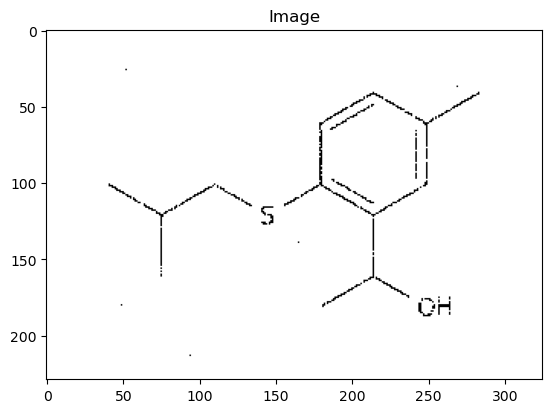

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3


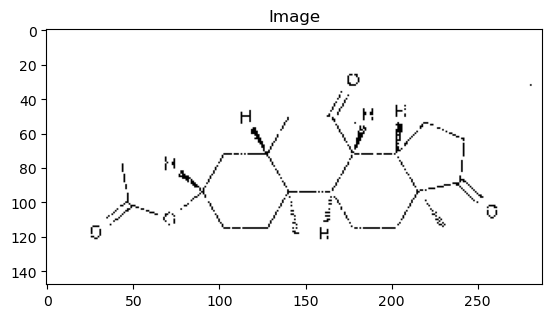

InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1


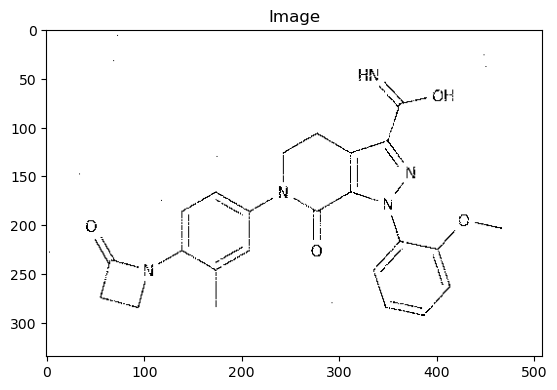

InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)


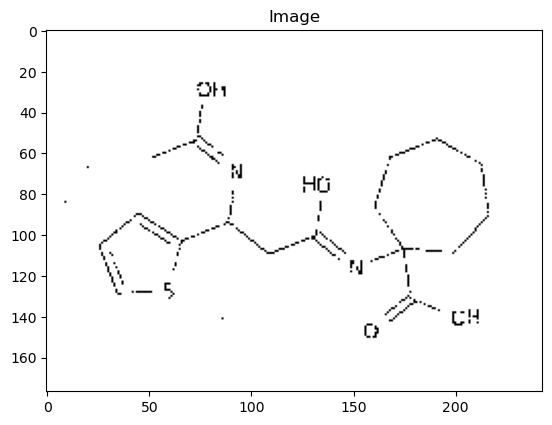

InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)


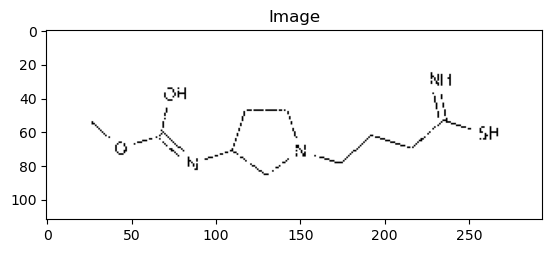

InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)


In [ ]:
for index,row in train[:5].iterrows():
    image_id = row["image_id"]
    image_path = "wowdao-generative-ai-applications-dataset/data/train/"+image_id[0]+"/"+image_id[1]+"/"+image_id[2]+"/"+image_id+".png"
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    plt.imshow(gray)
    plt.title('Image')
    plt.show()
    print(row["InChI"])
    print("="*64)

Let's look at an example from the training data where a lot of layers (11) are present: 'InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'.

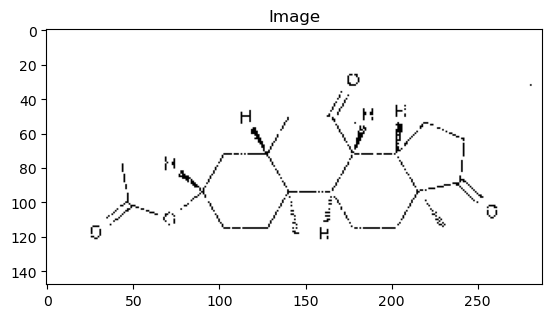

InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)


In [ ]:
image_id = "000019cc0cd2"
image_path = "wowdao-generative-ai-applications-dataset/data/train/"+image_id[0]+"/"+image_id[1]+"/"+image_id[2]+"/"+image_id+".png"
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
plt.imshow(gray)
plt.title('Image')
plt.show()
print(row["InChI"])
print("="*64)

<b>Important things to realize about the InChI training labels</b>

1) The prefix "InChI=1S/" can basically be ignored since all target labels have it. It indicates the version number (here version 1 "Standard"). 

2) The chemical formula: "C21H30O4" (21 carbon atoms, 30 hydrogen atoms and 4 oxygen atoms). Note that in case of atoms that need more letters like "Br" the second letter would be lower case. Also note that a single atom does not get a number behind it, so in an example like "C13H20OS" we do not write "C13H20O1S1".

3) The connection layer: in what order the atoms (other than hydrogen atoms) are connected (and what the side branches are): "c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20" (you can basically omit the "c" and just look at the rest of this sequence), so here atom 1 is connected to 12, there's a side branch to 22 etc.

4) The hydrogen layer how/how many hydrogen atoms are connected: "h13-16,19H,4-11H2,1-3H3" (you can basically omit the "h" and just look at the rest of this sequence)

5) tetrahedral stereochemistry of atoms: "t13-,14+,15+,16-,19-,20+,21+"

6) tetrahedral stereochemistry of allenes: "m1"

7) type of stereochemistry information: "s1"

8) In this example, there's no "/b" layer.

9) In this example, there's also no "/i" layer.

For the last two layers, examples with those included are

* with a "/b": 'InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12(10-19)16-20-15-8-4-2-6-13(15)17(22)21-16/h1-9,13H/b12-9+'

* with a "/i": 'InChI=1S/C24H50OSi/c1-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-25-26(5,6)24(2,3)4/h14-15H,7-13,16-23H2,1-6H3/b15-14-/i13D2,14D,15D'

Note that the layers need to be consistent. Also note that often characters belong togehther e.g. "15" means the number 15. It can either refer to a number of atoms, but could also refer to atom number 15 in the molecule. If you are tempted to use a language model, I think there's a decent amount of research suggesting that language models struggle a bit with understanding numbers when they treat them like any other word in the vocabulary, but that we can improve on that and it may be even harder to figure out the different meanings in the different layers of the notation.

# **Preprocessing**

<b>Tokenization</b>: Turn the text string into a list of "tokens". These are some sensible items that can be used to represent the text. In a normal sentence these could e.g. be words, some sub-words (e.g. syllables) or letters. Here, it may be more obvious to do something slightly different (see below).

In [ ]:
# Preprocess functions

# Separate the chemical elements and the subscripts of molecular formulas and then join them separated by a blank space
def split_form(form):
    string = ''
    for i in re.findall(r"[A-Z][^A-Z]*", form):
        elem = re.match(r"\D+", i).group()
        num = i.replace(elem, "")
        if num == "":
            string += f"{elem} "
        else:
            string += f"{elem} {str(num)} "
    return string.rstrip(' ')

# Separate the chemical elements and the subscripts of the connection layer and then join them separated by a blank space
def split_form2(form):
    string = ''
    for i in re.findall(r"[a-z][^a-z]*", form):
        elem = i[0]
        num = i.replace(elem, "").replace('/', "")
        num_string = ''
        for j in re.findall(r"[0-9]+[^0-9]*", num):
            num_list = list(re.findall(r'\d+', j))
            assert len(num_list) == 1, f"len(num_list) != 1"
            _num = num_list[0]
            if j == _num:
                num_string += f"{_num} "
            else:
                extra = j.replace(_num, "")
                num_string += f"{_num} {' '.join(list(extra))} "
        string += f"/{elem} {num_string}"
    return string.rstrip(' ')

# Tokenizer

class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

# **Backup**

Next I am going to generate 3 columns with the training dataset to start the development of the model and the tokenizer

* InChI_1: Molecular formula (for example, "C13H20OS")
* InChI_text: InChI separated by a blank space (chemical elements and the subscripts)
* InChI_length: Length of the tokens in InChI_text

Then, i will save the processed training dataset and the tokenizer

In [ ]:
# Preprocess the training dataset

#Extract the molecular formula (for example, "C13H20OS")
train['InChI_1'] = train['InChI'].progress_apply(lambda x: x.split('/')[1])
display(train.head())

# Separate the chemical elements and the subscripts of molecular formulas and connection layers and then join them separated by a blank space
train['InChI_text'] = train['InChI_1'].progress_apply(split_form) + ' ' + train['InChI'].apply(lambda x: '/'.join(x.split('/')[2:])).progress_apply(split_form2).values
display(train.head())

# Creating the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['InChI_text'].values)
torch.save(tokenizer, 'tokenizer.pth')
print('Saved tokenizer')

# Preprocessing the training dataset
lengths = []
tk0 = tqdm(train['InChI_text'].values, total=len(train))
for text in tk0:
    seq = tokenizer.text_to_sequence(text)
    length = len(seq) - 2
    lengths.append(length)
train['InChI_length'] = lengths
display(train.head())

#Here we save the processed training dataset and the tokenizer
train.to_pickle('train.pkl')
print('Saved preprocessed train.pkl')

  0%|          | 0/2424186 [00:00<?, ?it/s]

,image_id,InChI,InChI_1
0,000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3",C13H20OS
1,000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1",C21H30O4
2,0000252b6d2b,"InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)",C24H23N5O4
3,000026b49b7e,"InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)",C17H24N2O4S
4,000026fc6c36,"InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)",C10H19N3O2S


  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

,image_id,InChI,InChI_1,InChI_text
0,000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3",C13H20OS,"C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 - 5 - 10 ( 3 ) 7 - 12 ( 13 ) 11 ( 4 ) 14 /h 5 - 7 , 9 , 11 , 14 H , 8 H 2 , 1 - 4 H 3"
1,000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1",C21H30O4,"C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8 - 20 ( 2 ) 13 ( 10 - 14 ) 11 - 17 ( 23 ) 19 - 15 - 4 - 5 - 18 ( 24 ) 21 ( 15 , 3 ) 9 - 7 - 16 ( 19 ) 20 /h 13 - 16 , 19 H , 4 - 11 H 2 , 1 - 3 H 3 /t 13 - , 14 + , 15 + , 16 - , 19 - , 20 + , 21 + /m 1 /s 1"
2,0000252b6d2b,"InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)",C24H23N5O4,"C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 - 17 ( 14 ) 28 - 12 - 10 - 20 ( 28 ) 30 ) 27 - 11 - 9 - 16 - 21 ( 23 ( 25 ) 31 ) 26 - 29 ( 22 ( 16 ) 24 ( 27 ) 32 ) 18 - 5 - 3 - 4 - 6 - 19 ( 18 ) 33 - 2 /h 3 - 8 , 13 H , 9 - 12 H 2 , 1 - 2 H 3 , ( H 2 , 25 , 31 )"
3,000026b49b7e,"InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)",C17H24N2O4S,"C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 ( 14 - 7 - 6 - 10 - 24 - 14 ) 11 - 15 ( 21 ) 19 - 17 ( 16 ( 22 ) 23 ) 8 - 4 - 2 - 3 - 5 - 9 - 17 /h 6 - 7 , 10 , 13 H , 2 - 5 , 8 - 9 , 11 H 2 , 1 H 3 , ( H , 18 , 20 ) ( H , 19 , 21 ) ( H , 22 , 23 )"
4,000026fc6c36,"InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)",C10H19N3O2S,"C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 - 8 - 4 - 6 - 13 ( 7 - 8 ) 5 - 2 - 3 - 9 ( 11 ) 16 /h 8 H , 2 - 7 H 2 , 1 H 3 , ( H 2 , 11 , 16 ) ( H , 12 , 14 )"


Saved tokenizer


  0%|          | 0/2424186 [00:00<?, ?it/s]

,image_id,InChI,InChI_1,InChI_text,InChI_length
0,000011a64c74,"InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3",C13H20OS,"C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 - 5 - 10 ( 3 ) 7 - 12 ( 13 ) 11 ( 4 ) 14 /h 5 - 7 , 9 , 11 , 14 H , 8 H 2 , 1 - 4 H 3",59
1,000019cc0cd2,"InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1",C21H30O4,"C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8 - 20 ( 2 ) 13 ( 10 - 14 ) 11 - 17 ( 23 ) 19 - 15 - 4 - 5 - 18 ( 24 ) 21 ( 15 , 3 ) 9 - 7 - 16 ( 19 ) 20 /h 13 - 16 , 19 H , 4 - 11 H 2 , 1 - 3 H 3 /t 13 - , 14 + , 15 + , 16 - , 19 - , 20 + , 21 + /m 1 /s 1",108
2,0000252b6d2b,"InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)",C24H23N5O4,"C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 - 17 ( 14 ) 28 - 12 - 10 - 20 ( 28 ) 30 ) 27 - 11 - 9 - 16 - 21 ( 23 ( 25 ) 31 ) 26 - 29 ( 22 ( 16 ) 24 ( 27 ) 32 ) 18 - 5 - 3 - 4 - 6 - 19 ( 18 ) 33 - 2 /h 3 - 8 , 13 H , 9 - 12 H 2 , 1 - 2 H 3 , ( H 2 , 25 , 31 )",112
3,000026b49b7e,"InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)",C17H24N2O4S,"C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 ( 14 - 7 - 6 - 10 - 24 - 14 ) 11 - 15 ( 21 ) 19 - 17 ( 16 ( 22 ) 23 ) 8 - 4 - 2 - 3 - 5 - 9 - 17 /h 6 - 7 , 10 , 13 H , 2 - 5 , 8 - 9 , 11 H 2 , 1 H 3 , ( H , 18 , 20 ) ( H , 19 , 21 ) ( H , 22 , 23 )",108
4,000026fc6c36,"InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)",C10H19N3O2S,"C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 - 8 - 4 - 6 - 13 ( 7 - 8 ) 5 - 2 - 3 - 9 ( 11 ) 16 /h 8 H , 2 - 7 H 2 , 1 H 3 , ( H 2 , 11 , 16 ) ( H , 12 , 14 )",72


Saved preprocessed train.pkl
